In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [24]:
plt.rcParams['font.family'] = 'sans-serif'

# Helper functions

In [25]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [26]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[n:-n] = smoothed[n:-n]
    return vals

In [27]:
def get_df(base, z, pfiles, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': []}
    task_dir = f'{base}_{net_yaml}_dim{z}'
    task_dir = f'{engram_dir}pickles/{task_dir}/'
    if not os.path.exists(task_dir): return
    for pickle_file in pfiles:
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_score = results['valid_score']
        valid_steps = results['valid_steps_per_ep']
        episode = results['episode']
        model = results['model']
        step = results['step']
        for i in range(len(valid_score)):
            if valid_score[i] == None: continue
            data['valid_score'].append(valid_score[i])
            data['valid_steps'].append(valid_steps[i])
            data['dims'].append(z)
            data['episode'].append(episode[i])
            _model = model[i].split(base+'_')[-1]
            data['model'].append(_model)
            data['z'].append(z)
            data['step'].append(step[i])
    df = pd.DataFrame(data)
    return df

In [28]:
def find_model_directories(directory_path, model):
    all_files_dirs = os.listdir(directory_path)
    pattern = f'\\b{model}(\\d*)\\b'  # Using word boundaries to ensure complete matches
    matches = [re.search(pattern, item) for item in all_files_dirs]
    
    # Filter out None values (i.e., items that didn't match) and return a list of tuples
    return [(match.group(0), int(match.group(1)) if match.group(1) else None) for match in matches if match]

# Initial Gridworld Experiment

In [29]:
base = 'new_gridworld8x8_shuffobs'
net_yaml = 'dm'
z = 11

In [30]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

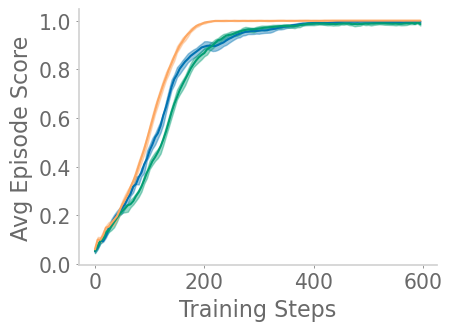

In [32]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro0', 'g0_-2_entro-1']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    
    means = smooth(episodes, means, 5)
    mean_lowerbound = smooth(episodes, mean_lowerbound)
    mean_upperbound = smooth(episodes, mean_upperbound)
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
#plt.xlim(-1, 420)
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Testing $\gamma$ transfer

In [42]:
base = 'frozentransfer_new_gridworld8x8_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [43]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

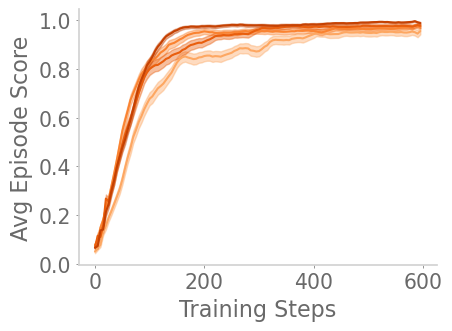

In [44]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)   
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

In [20]:
base = 'new_gridworld8x8_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [21]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

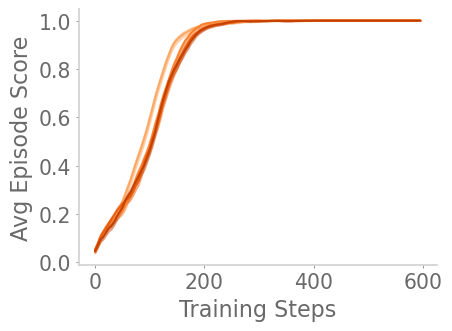

In [22]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Modifying epsilon to test transfer for $\gamma$

In [55]:
base = 'frozenrandomtransfer_new_gridworld8x8_eps0.1_shuffobs'
net_yaml = 'dm_large_q'
z = 17

In [56]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

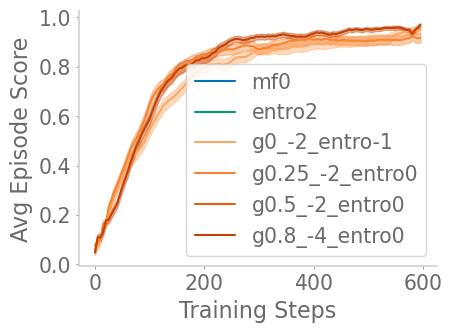

In [59]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=[
    'C0', 'C2',
    colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*0.75))
for _idx, model in enumerate(
     ['mf0', 'entro2', 'g0_-2_entro-1', 'g0.25_-2_entro0',
     'g0.5_-2_entro0', 'g0.8_-4_entro0']
    #np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = smooth(episodes, means, 5)
    sems = smooth(episodes, sems, 5)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
        
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.tight_layout()
plt.legend()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [197]:
base = 'gridworld8x8_largeencoder'
net_yaml = 'dm_large_encoder'
z = 6

In [198]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [199]:
np.unique(df['model'])

array(['entro-1', 'entro1', 'entro_0', 'g0.25_-3_entro-1',
       'g0.25_-3_entro0', 'g0.5_-3_entro-1', 'g0.5_-3_entro0',
       'g0.8_-4_entro-1', 'g0.8_-4_entro0', 'g0_-2_entro-1',
       'g0_-2_entro0'], dtype=object)

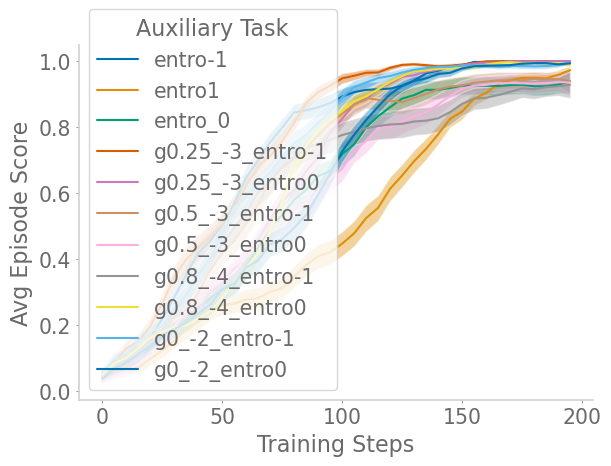

In [200]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(new_df['model'])
    #['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model)#, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4#, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [6]:
base = 'new_altT_eps0.4_tlen9_mlen5'
net_yaml = 'dm'
z = 24

In [7]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [8]:
np.unique(df['model'])

array(['g0_-2_entro-2'], dtype=object)

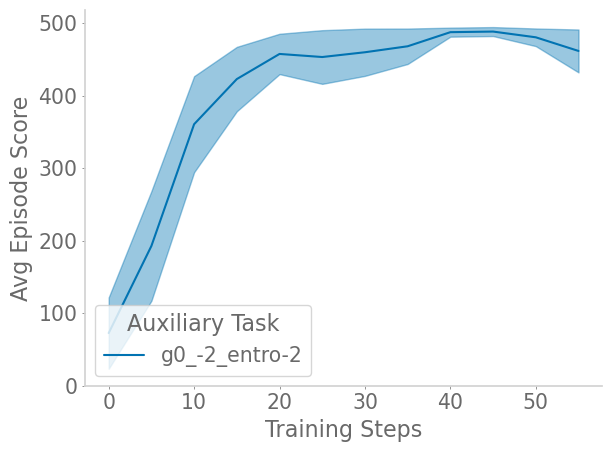

In [9]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(new_df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [12]:
base = 'poorttask'
net_yaml = 'dm'
z = 32

In [13]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [14]:
np.unique(df['model'])

array(['mf0'], dtype=object)

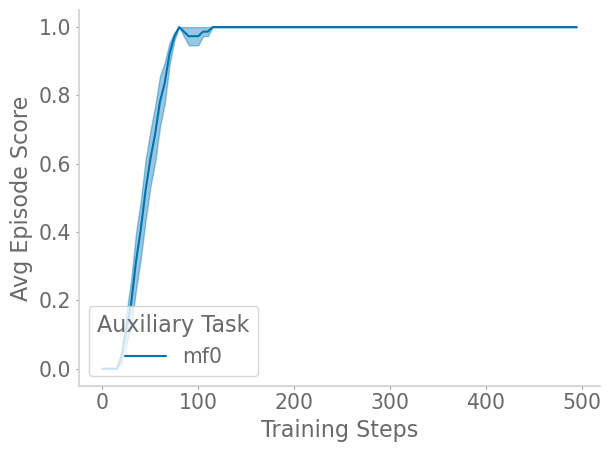

In [15]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(df['model'])
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()